<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Correlation vs. Autocorrelation vs. Partial Autocorrelation

### Implementing the formulas, and understanding the plots.

_Author: Dan Wilhelm_

---

### Table of Contents

1. [Motivation: The Mystery](#mys)
2. [Part One: Correlation](#part1)
3. [Part Two: Autocorrelation - Different from Correlation?](#part2)
    + [EXTRA: `Series` vs. `Series.values`](#series)
    + [EXTRA: The Pandas autocorrelation plot](#pandas)
4. [Part Three: Partial Autocorrelation](#part3)

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [2]:
# Read in airline data.
air = pd.read_csv('./data/airline-passengers.csv', parse_dates=['Month'])

# Set the index to be month over month.
air.set_index('Month', inplace=True)

In [3]:
# Manually generate lags from 1-50
LAG_FEATURES = {i: f'lag_{i}' for i in range(1, 50)}

for i,feature_name in LAG_FEATURES.items():
    air[feature_name] = air.Passengers.shift(i)

<a id="mys"></a>
## Motivation: The Mystery

Using three different methods to compute correlation of the passengers against lag 13, we seem at first to get three completely different numbers for correlation! Why?

1. Lag 13 and lag 0 have a Pearson correlation coefficient of 0.948:

0.9481066160592018

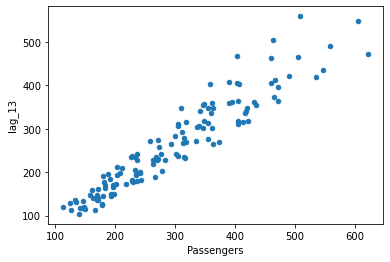

In [4]:
air.plot.scatter(x='Passengers', y='lag_13');
air.Passengers.corr(air.lag_13)

2. However, looking at the acf (autocorrelation function), we notice the autocorrelation at lag 13 is much lower -- only 0.731:

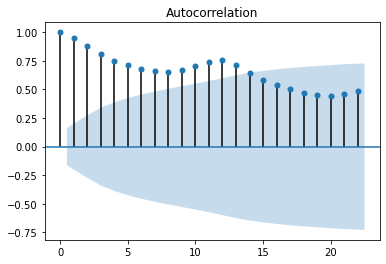

In [5]:
plot_acf(air.Passengers);

3. Even more confusingly, we notice the pacf (partial autocorrelation function) is negative at lag 13:

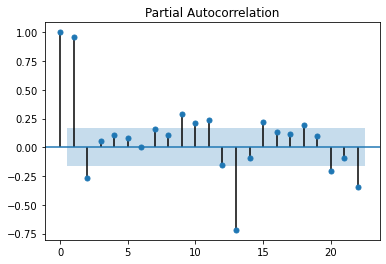

In [6]:
plot_pacf(air.Passengers);

Why? Let's figure it out by implementing each of these from scratch.

<a id="part1"></a>
## Part One: Correlation

Let's make sure the Pearson correlation coefficient is computed similarly across Pandas, Numpy, and Scipy:

In [7]:
#### Computing the correlation between lag 0 and lag 13 of the graphed points ####

y0 = air.Passengers[13:]   # Lag 0 - Remove initial numbers for which there is no lag-13
y13 = air.lag_13[13:]      # Lag 13

nsamples = len(y0)         # By default, Pandas and Numpy compute population std dev

# Correlation functions -- all give the same result!
print('=== Correlation with lag 0 and lag 13 ===')
print('Pandas (corr):\n', y0.corr(y13))
print('Pandas (autocorr):\n', air.Passengers.autocorr(13))  # Interestingly, Pandas autocorr is just the Pearson corr coeff!
print('Numpy:\n', np.corrcoef(y0, y13))
print('Scipy Pearson:\n', pearsonr(y0, y13))

=== Correlation with lag 0 and lag 13 ===
Pandas (corr):
 0.9481066160592018
Pandas (autocorr):
 0.9481066160592018
Numpy:
 [[1.         0.94810662]
 [0.94810662 1.        ]]
Scipy Pearson:
 (0.9481066160592015, 4.713226523795462e-66)


---

Now, let's verify this using the formula for correlation!

$$
\begin{eqnarray*}
Corr(Y_t, Y_{t-k}) = \frac{Cov(X, Y)}{Stdev(X) \cdot Stdev(Y)} = \frac{E[(X - \bar{X})(Y - \bar{Y})]}{E[(X - \bar{X})^2] \cdot E[(Y - \bar{Y})^2]}.
\end{eqnarray*}
$$

When applied to a time series, $X$ and $Y$ are different portions of the time series. 

- $X$ may contain the first $N-k$ points.
- $Y$ may contain the last $N-k$ points.
- Hence, $\bar{X}$ and $\bar{Y}$ typically differ.

In the next section, you will see that in autocorrelation we still have $N-k$ pairs of points. However, we only use one mean -- that of the entire dataset.

### Let's verify how correlation is computed.

In [8]:
def corr(y0, ylag):
    """Returns the correlation of two arrays y0 and ylag."""
    
    def cov(y, ylag):  # Covariance
        return np.mean((y - np.mean(y)) * (ylag - np.mean(ylag)))
    
    def stdev(y):      # Standard Deviation (note Cov(y, y) = Var(y))
        return np.sqrt(cov(y, y))
    
    return cov(y0, ylag) / (stdev(y0) * stdev(ylag))


# TEST
y0 = air.Passengers[13:]   # Lag 0 - Remove initial numbers for which lag13 is NaN
y13 = air.lag_13[13:]      # Lag 13 - Remove initial NaNs

corr_y0_y13 = corr(y0, y13)

print('Correlation at lag 13 (by formula):', corr_y0_y13)
print('Same as Pandas?', np.isclose(y0.corr(y13), corr_y0_y13))

Correlation at lag 13 (by formula): 0.948106616059202
Same as Pandas? True


<a id="part2"></a>
## Part Two: Autocorrelation - Different than Correlation?

Autocorrelation IS the Pearson correlation.

However, for time series, `statsmodels` assumes stationarity (i.e. the mean is invariant to time shifts).

This reduces the Pearson correlation to a simpler form called the **sample autocorrelation function**. 

> NOTE: This function is normalized differently than Pearson (dividing by a lag-independent denominator), which is why sample auto-correlation decreases with lag. 

---

Let's see what it looks like:

Autocorrelation values: [1.         0.94804734 0.87557484 0.80668116 0.75262542 0.71376997
 0.6817336  0.66290439 0.65561048 0.67094833 0.70271992 0.74324019
 0.76039504 0.71266087 0.64634228 0.58592342 0.53795519 0.49974753
 0.46873401 0.44987066 0.4416288  0.45722376 0.48248203 0.51712699
 0.53218983 0.49397569 0.43772134 0.3876029  0.34802503 0.31498388
 0.28849682 0.27080187 0.26429011 0.27679934 0.2985215  0.32558712
 0.3370236  0.30333486 0.25397708 0.21065534 0.17217092]


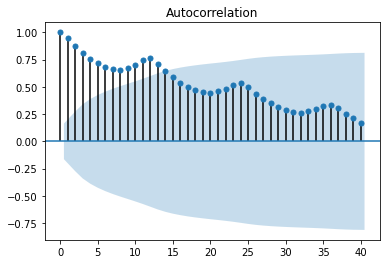

In [9]:
# Let's make an autocorrelation plot!
plot_acf(air.Passengers, lags=40);

# Actual autocorr values
sm_autocorr = acf(air.Passengers, fft=False) 
print('Autocorrelation values:', sm_autocorr)

The above plot computes the significance levels using [Bartlett's formula](https://en.wikipedia.org/wiki/Correlogram#Statistical_inference_with_correlograms). By default, 95% confidence intervals are displayed (`alpha=0.05` by default).

Note that the lag-13 autocorrelation is only 0.713, which is much less than the 0.948 that we computed above.

What happened? Let's see how the formulas differ!

---
### The Stationarity Assumption


Here is what Pearson correlation becomes when simplified under the assumption of stationarity (i.e. where the mean is invariant to time shifts):

- $\bar{Y}$ is the mean of all points.
- $Y_0$ is the final $N-k$ points. 
- $Y_k$ is the first $N-k$ points.

$$
r_{k} = \frac{Autocov(Y, k)}{Var(Y)} = \frac{E[(Y_0 - \bar{Y})(Y_k - \bar{Y})]}{E[(Y - \bar{Y})^2]}.
$$

Note that the numerator's autocovariance is summed across $N-k$ points in total, just as in the correlation.

> Note that as the lag increases, the autocorrelation will decrease:
> - As the lag increases, the numerator decreases since fewer points are summed over. 
> - The denominator is independent of lag! 

---

### Implementation

Let's implement it! Breaking it down to more clearly see the summations:

$$
r_{k} = \frac{Autocov(Y, k)}{Var(Y)} = \frac{E[(Y_0 - \bar{Y})(Y_k - \bar{Y})]}{E[(Y - \bar{Y})^2]} = \frac{\frac{1}{N}\sum_{i=1}^{N-k}(Y_{i} - \bar{Y})(Y_{i+k} - \bar{Y})} {\frac{1}{N}\sum_{i=1}^{N}(Y_{i} - \bar{Y})^{2} }.
$$

Also note that $Var(Y) = Autocov(Y, 0)$.

In [10]:
def autocorr(y, k):
    """Returns the autocorrelation of array y at lag k."""

    def autocov(y, k):   # Autocovariance
        N, u = len(y), y.mean()        
        return np.sum((y[:N-k] - u) * (y[k:] - u)) / float(N)

    return autocov(y, k) / autocov(y, 0)   # AutoCov(y, 0) = Var(y)


# TEST
y0 = air.Passengers.values   # Numpy array

sm_acf = acf(y0, fft=False)
our_acf = np.array([autocorr(y0, lag) for lag in range(0, 41)])

print('Same as statsmodels?', np.all(np.isclose(sm_acf, our_acf)))

Same as statsmodels? True


---
<a id="series"></a>
#### EXTRA: `Series` vs. `Series.values`

NOTE: `Series` (pandas Series) and `Series.values` (numpy array) are not interchangeable! 

- Pandas `Series`: Corresponding indices are matched up then multiplied together.
- Numpy `ndarray`: Always multiplied elementwise. 

Example:

In [11]:
x = pd.Series([1, 2, 3])

series_mult = x[:2] * x[1:]                # Only index 1 is in both, so only it is multiplied.
numpy_mult = x.values[:2] * x.values[1:]   # Element-wise mult: [1, 2] * [2, 3] = [2, 6].

print('Series multiplication:\n', series_mult) 
print()
print('Numpy array multiplication:\n', numpy_mult)

Series multiplication:
 0    NaN
1    4.0
2    NaN
dtype: float64

Numpy array multiplication:
 [2 6]


---

<a id="pandas"></a>
#### EXTRA: The Pandas autocorrelation plot

Interestingly, Pandas also has an autocorrelation plotting function! Except for its significance levels, it agrees with the `statsmodels` plot.

You may be surprised how [independent and simple its source code is](https://github.com/pandas-dev/pandas/blob/526f40431a51e1b1621c30a4d74df9006e0274b8/pandas/plotting/_matplotlib/misc.py#L405).

Note the confidence interval is constant at a level indicative of randomness, or equivalently whether the [first lag correlation is non-random](https://en.wikipedia.org/wiki/Correlogram#Statistical_inference_with_correlograms) (using $SE(r_1)$). Note that `statsmodels` updates the confidence interval [based on the lag](https://en.wikipedia.org/wiki/Correlogram#Statistical_inference_with_correlograms) (using $SE(r_h)$).

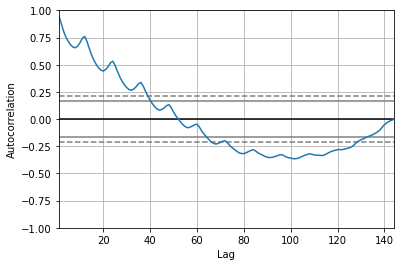

In [12]:
# Let's see the same plot in Pandas
pd.plotting.autocorrelation_plot(air.Passengers);   # 95% (dashed) / 99% (solid) confidence bands

PS - Remember from above how Panda's `Series.autocorr()` function gave the Pearson correlation coefficient, while the above autocorrelation graph gives the **sample** autocorrelation? It's confusing why!

It turns out there is an open (but stagnant) issue about this on GitHub: https://github.com/pandas-dev/pandas/issues/24608

---

<a id="part3"></a>
## Part Three: Partial Autocorrelation

Finally, let's try to understand partial correlation and partial autocorrelation!

We finally looked at the partial autocorrelation function and observed a **negative** pac at lag 13:

[ 1.          0.95893198 -0.32983096  0.2018249   0.14500798  0.25848232
 -0.02690283  0.20433019  0.15607896  0.56860841  0.29256358  0.8402143
  0.61268285 -0.66597616 -0.38463943  0.0787466  -0.02663483 -0.05805221
 -0.04350748  0.27732556 -0.04046447  0.13739883  0.3859958   0.24203808
 -0.04912986 -0.19599778 -0.15443575  0.04484465  0.18371541 -0.0906113
 -0.06202938  0.34827092  0.09899499 -0.08396793  0.36328898 -0.17956662
  0.15839435  0.06376775 -0.27503705  0.2707607   0.32002003]


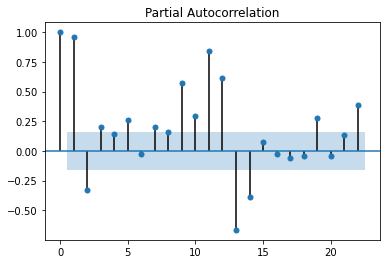

In [23]:
y0 = air.Passengers.values   # Numpy array

# NOTE: There are other methods of computing the PACF, 
#   but here we use linear regression since it is very familiar to us
#   from this course. 
# The other methods also yield a similar negative spike, but differ in normalization.
plot_pacf(y0, method='ols');
print(pacf(y0, method='ols'))   # Lag 13 == -0.6660


# ALSO: The OLS method does not result in standardized values, 
#    so I believe the confidence interval is not valid.

How can the PACF of lag 13 be negative when the time series data has an upward trend? 

> Partial autocorrelation controls for all lags prior to it. After controlling for them, there is still unexplained variance. This unexplained variance has a negative correlation.

**Conceptually:** Recall that "sunglass-wearing" does not CAUSE "ice cream consumption" just because they are highly correlated! Instead, a third variable "temperature" is what affects them both, and it is also highly correlated with them both. 

We can use partial correlation to discover this. If we control for "temperature," we discover that "sunglass-wearing" is no longer important for predicting "ice cream consumption." (Why? The data is mostly explained by "temperature" alone.)

---

#### How can we control for the other lags? Using multi-variate linear regression!

Recall how we interpret each coefficient in OLS (Ordinary Least Squares) regression:

> $\hat{y} = b_0 + b_1x_1 + b_2x_2 + b_3x_3$. 
> 
> + Let's interpret $b_3$: 
> "**Controlling for $x_1$ and $x_2$** (i.e. with them held constant), then y is associated with an average increase of $b_3$ for each unit increase of $x_3$."

This is exactly what we are looking for! So, we just need to do an OLS regression up to and including the lag of interest. The **coefficient** of the lag of interest will be our PACF.

**NOTE:** This particular method does not standardize the coefficients, but it **is** a standard way of calculating PACF. (For example, the Pearson correlation is the _standardized_ slope of a linear regression.) This is not as important now, since we are just using these to create another model. However, know that our final results will hence differ from using the formal sample partial correlation equation, since it uses a different normalization method. Know that you can always research and experiment with the other calculation methods in the `statsmodels` `pacf` function.

---
We'll start with a classic linear regressor:

In [14]:
import statsmodels.api as sm

def fit_linreg(X, y):
    """Returns a fitted linear regression model."""
    X_train = X.copy()
    X_train = sm.add_constant(X_train)
    
    # Drop any NaN rows (present due to lags)
    X_train = X_train.dropna()
    y_train = y[X_train.index]
    
    lm = sm.OLS(y_train, X_train)
    lm = lm.fit()
    
    return lm

Now, let's fit a linear regression to find the PACF at lag 13.

+ Target: Passengers
+ Variables: Lag 1, Lag 2, ..., Lag 13
+ The PACF is the Lag 13 coefficient.

In [15]:
### Find PACF at lag 13
FEATURES = [f'lag_{i}' for i in range(1, 14)]

X_na = air[FEATURES + ['Passengers']].dropna()
lr = fit_linreg(X_na[FEATURES], X_na['Passengers'])

print('PACF at lag 13 = ', lr.params['lag_13'])
lr.summary()

PACF at lag 13 =  -0.6659761598719791


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     994.9
Date:                Thu, 13 Aug 2020   Prob (F-statistic):          3.91e-113
Time:                        23:31:17   Log-Likelihood:                -497.99
No. Observations:                 131   AIC:                             1024.
Df Residuals:                     117   BIC:                             1064.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1490      3.023      1.703      0.091      -0.839      11.137
lag_1          0.7608      0.074     10.287      0.000       0.614       0.907
lag_2         -0.0853      0.073     -1.161      0.248      -0.231       0.060
lag_3          0.0442      0.074      0.597      0.551      -0.102       0.191
lag_4         -0.0418      0.075     -0.557      0.579      -0.190       0.107
lag_5          0.0543      0.075      0.722      0.472      -0.095       0.203
lag_6         -0.0528      0.074     -0.715      0.476      -0.199       0.093
lag_7          0.0332      0.073      0.454      0.651      -0.112       0.178
lag_8         -0.0997      0.074     -1.356      0.178      -0.245       0.046
lag_9          0.1456      0.075      1.945      0.054      -0.003       0.294
lag_10        -0.1259      0.076     -1.646      0.102      -0.277       0.026
lag_11         0.1436      0.077      1.860      0.065      -0.009       0.296
lag_12         0.9071      0.078     11.616      0.000       0.752       1.062
lag_13        -0.6660      0.083     -7.989      0.000      -0.831      -0.501
==============================================================================
Omnibus:                        8.377   Durbin-Watson:                   2.404
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               17.135
Skew:                           0.047   Prob(JB):                     0.000190
Kurtosis:                       4.769   Cond. No.                     3.21e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

Finally, let's make sure we're correct by comparing our results with `statsmodels`:

In [16]:
def our_pacf(X, nlags=40):
    """
    Returns an ndarray of pacfs from lag 0 to nlags.
        Assumes lags are stored in X as 'lag_1', 'lag_2', ..., 'lag_{nlags}'.
    """
    
    pacs = [1.0]  # Pacf requires a lag, so we define the first as 1.0.
    
    # nlags refers to the largest number of lags to hold constant
    for lag in range(2, nlags+2):
        FEATURES = [f'lag_{i}' for i in range(1, lag)]
        
        X_na = X[FEATURES + ['Passengers']].dropna()
        lr = fit_linreg(X_na[FEATURES], X_na['Passengers'])

        pacs.append(lr.params[-1])   # PACF = coeff of largest lag
    
    return np.array(pacs)


## TEST
sm_pacf = pacf(y0, method='ols')
our_pacf = our_pacf(air)

print('PACF the same as statsmodels?', np.all(np.isclose(sm_pacf, our_pacf)))

PACF the same as statsmodels? True


---

Recall why we use PACF. We are looking for which lags to include in a linear regression model, which requires **independent variables**. 

Autocorrelation from Part Two alone is not enough to completely determine which lags independently account for high correlations. For example, a lag 1 effect may account for nearly all of the high correlations. We can solve this problem by controlling for lag 1 when finding the lag 2 coefficient.

---
## How do we interpret the result? What do we do with lag 13?

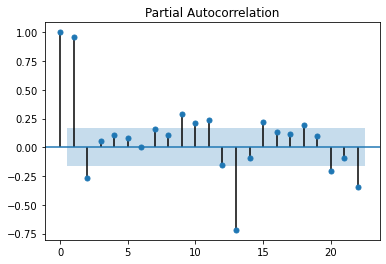

In [27]:
# Switched to default so the confidence interval makes sense.
plot_pacf(air.Passengers);

First, keep in mind that by default a 95% confidence interval for non-significance is shown. Since we are displaying over 20 points, it is likely that at least one of them is -- by chance alone -- outside of the interval.

Due to this, we can choose to only incorporate variables with PACF values strongly outside of the interval as part of our model. If the model does not perform as hoped, we can try some additional variables.

### What about lag 13? 

We found that lag 13 explains a significant amount of the variance that was unexplained by the previous lags. The fact that the lag 13 PACF is highly significant means we should include it in our model. Any further meaning of the magnitude is based on an average change when holding the other lags constant, which is much more difficult to find useful. So in this case, we only conclude it would be a good choice as an independent variable in our linear time series model.

---

# Conclusion

We did it!

We implemented Pearson correlation, sample autocorrelation, and partial autocorrelation. Now, we have a better understanding of exactly why these values are what they are.

Finally, keep in mind these are all linear methods. There could be a relationship between the lags that is non-linear that these will fail to detect.